# Research Project Daily

# Import Libraries

In [1]:
#Import Libraries

import warnings
warnings.filterwarnings("ignore")

import os
import pandas as pd
import numpy as np
import talib
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import linear_model
from sklearn.metrics import accuracy_score,log_loss,precision_score,roc_auc_score,confusion_matrix
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Import and Downlad Data

In [2]:
#ImportData

path = "C:/Users/User/Desktop/Research Project/Top40_Investing"
os.chdir(path)

df = pd.read_csv("NPN.csv", index_col=0, parse_dates=True)
df = df[['Price', 'Open', 'High', 'Low', 'Volume']]

df1 = df.copy()

stock_high = df['High']
stock_low = df['Low']
stock_open = df['Open']
stock_close = df['Price']
stock_volume = df['Volume']


# Oscillators and Trend Following Indicators

# 1. MACD and MACD HISTOGRAM

In [3]:
#Compute MACD and MACD Histogram
macd, macdsignal, macdhist = talib.MACD(stock_close, fastperiod=26, slowperiod=12, signalperiod=9)

dict = {'MACD': macd, 'MSIG': macdsignal}
macdata = []
macdata = pd.DataFrame(data=dict)
macdata.dropna(inplace=True)

macdata['MACD_Signal1'] = macdata.apply(lambda x : 1 if x['MACD'] > x['MSIG'] else 0, axis = 1)

n_days = len(macdata['MACD'])
Signal = macdata['MACD_Signal1']
psy = []

for d in range(0, n_days):
    
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
macdata['MACD_Signal'] = psy

del macdata['MACD_Signal1']

dict = {'MHIST': macdhist, 'PrevMHIST': macdhist.shift(1)}
machdata = []
machdata = pd.DataFrame(data=dict)
machdata.dropna(inplace=True)

machdata['MHIST_Signal1'] = machdata.apply(lambda x : 1 if x['MHIST'] > x['PrevMHIST'] else 0, axis = 1)

n_days = len(machdata['MHIST'])
Signal = machdata['MHIST_Signal1']
psy = []

for d in range(0, n_days):
    
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
machdata['MHIST_Signal'] = psy

del machdata['MHIST_Signal1']


# 2. Average Directional Index (ADX)

In [4]:
#Compute Average Directional Index (ADX)
adx = talib.ADX(stock_high, stock_low, stock_close, timeperiod=14)

dict = {'Close': stock_close, 'ADX': adx }

adxdata = []
adxdata = pd.DataFrame(data=dict)
adxdata.dropna(inplace=True)

adxdata['adx1'] = adxdata.apply(lambda x : 1 if x['ADX'] > 25 else 0, axis=1)
adxdata['adx2'] = adxdata.apply(lambda x : -1 if x['ADX'] < 20 else 0, axis=1)

adxdata['Signw'] = adxdata.apply(lambda x : x['adx1'] + x['adx2'] , axis=1)

n_days = len(adxdata['ADX'])
Signal = adxdata['Signw']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
        
adxdata['Trend'] = psy

del adxdata['Signw']
del adxdata['adx1']
del adxdata['adx2']


# 3. Relative Strength Index (RSI)

In [5]:
#Compute Relatie Strength Index (RSI)
rsi = talib.RSI(stock_close, timeperiod=14)

dict = {'Close': stock_close, 'RSI': rsi }

rsidata = []
rsidata = pd.DataFrame(data=dict)
rsidata.dropna(inplace=True)

rsidata['rsi1'] = rsidata.apply(lambda x : 1 if x['RSI'] < 30 else 0, axis=1)
rsidata['rsi2'] = rsidata.apply(lambda x : -1 if x['RSI'] > 70 else 0, axis=1)
rsidata['Sign1'] = rsidata.apply(lambda x : x['rsi1'] + x['rsi2'], axis=1)

n_days = len(rsidata['RSI'])
Signal = rsidata['Sign1']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
    
    elif Signal[d] == 0:
        psycology = 0
        psy.append(psycology)
        
rsidata['Psycology'] = psy

del rsidata['Sign1']
del rsidata['rsi1']
del rsidata['rsi2']


# Volatility Indicators

# 4. Bollinger Bands

In [6]:
#Compute Bollinger Bands
upper, middle, lower = talib.BBANDS(stock_close, timeperiod=26)

dict = {'Close': stock_close, 'Middle': middle, 'Upper': upper, 'Lower': lower }

bbdata = []
bbdata = pd.DataFrame(data=dict)
bbdata.dropna(inplace=True)

#Generate the Long and Short Signals
n_days = len(bbdata['Middle'])
cash = 1
stock = 0

position = []

spread = stock_close
ma = middle
upper_band = upper
lower_band = lower

for d in range(0, n_days):
    
    # Long if spread < lower band & if not bought yet
    if spread[d] < lower_band[d] and cash == 1:
        signal = 1
        cash = 0
        stock = 1
        position.append(signal)
        
        
    # Take Profit if spread > moving average & if already bought
    elif spread[d] > ma[d] and stock == 1:
        signal = 3
        cash = 1
        stock = 0
        position.append(signal)
        
    # Short if spread > upper band and no current position
    elif spread[d] > upper_band[d] and cash == 1:
        signal = -1
        cash = 0
        stock = -1
        position.append(signal)
        

    # Take Profit if spread < moving average & if already short
    elif spread[d] < ma[d] and stock == -1:
        signal = 3
        cash = 1
        stock = 0
        position.append(signal)
    
    else:
        signal = 0
        position.append(signal)
        
bbdata['Position1'] = position
bbdata['Position1'] = bbdata['Position1'].replace(to_replace=0, method= 'ffill')
bbdata['Position1'] = bbdata['Position1'].replace(3,0)
bbdata['Position'] = bbdata['Position1']

del bbdata['Position1']

t_days = len(bbdata['Middle'])
Signal = bbdata['Position']
pos = []

for d in range(0, t_days):
    if Signal[d] == 0:
        strategy = 0
        pos.append(strategy)
    
    elif Signal[d] == 1:
        strategy = 1
        pos.append(strategy)
    
    elif Signal[d] == -1:
        strategy = 0
        pos.append(strategy)

bbdata['Strategy'] = pos


# Volume Indicators

# 5. Force Index

In [7]:
#Force Index Function
def ForceIndex(Volume, Close):
    dict = {'Volume': Volume, 'Close': Close}
    df = pd.DataFrame(data=dict)
    df.dropna(inplace=True)
    
    FI = df['Volume']*(df['Close'] - df['Close'].shift(1))
    
    return FI

#Compute Force Index
fi = ForceIndex(stock_volume,stock_close)

efi = talib.EMA(fi, timeperiod=13)

dict = {'Close': stock_close, 'EFI': efi }

efidata = []
efidata = pd.DataFrame(data=dict)
efidata.dropna(inplace=True)


efidata['efi_sign'] = efidata.apply(lambda x : 1 if x['EFI'] > 0 else -1, axis=1)

n_days = len(efidata['EFI'])
Signal = efidata['efi_sign']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
      
efidata['Psycology'] = psy

del efidata['efi_sign']


# Classify Next Weeks Stock Move

In [8]:
#Compute Weekly Stock Move and Iddentify if > 0.003
stock_move = stock_close.shift(-5)

dict = {'Close': stock_close, 'Move': stock_move}

sdmdata = []
sdmdata = pd.DataFrame(data=dict)
sdmdata.dropna(inplace=True)

sdmdata['sign'] = sdmdata.apply(lambda x : 1 if np.log(x['Move']/x['Close']) > 0 else -1, axis=1)


n_days = len(sdmdata['Move'])
Signal = sdmdata['sign']
psy = []

for d in range(0, n_days):
    if Signal[d] == 1:
        psycology = 1
        psy.append(psycology)
    
    elif Signal[d] == -1:
        psycology = 0
        psy.append(psycology)
    
      
sdmdata['Next Week Move'] = psy

del sdmdata['sign']


# Consolidate Technical Indicators and Next Day's Stock Move

In [9]:
#Data
Close = pd.DataFrame({'Close': stock_close})
NWM = pd.DataFrame({'Next Week Move': sdmdata['Next Week Move']})
MACD = pd.DataFrame({'MACD': macdata['MACD_Signal']})
ADX = pd.DataFrame({'ADX': adxdata['Trend']})
MHIST = pd.DataFrame({'MHIST': machdata['MHIST_Signal']})
RSI = pd.DataFrame({'RSI': rsidata['Psycology']})
BB = pd.DataFrame({'BB': bbdata['Strategy']})
FI = pd.DataFrame({'FI': efidata['Psycology']})

#Merge
merge1 = pd.merge(Close, NWM, left_index=True, right_index=True, how='outer')
merge2 = pd.merge(merge1, MACD, left_index=True, right_index=True, how='outer')
merge3 = pd.merge(merge2, ADX, left_index=True, right_index=True, how='outer')
merge4 = pd.merge(merge3, MHIST, left_index=True, right_index=True, how='outer')
merge5 = pd.merge(merge4, RSI, left_index=True, right_index=True, how='outer')
merge6 = pd.merge(merge5, BB, left_index=True, right_index=True, how='outer')
df_daily = pd.merge(merge6, FI, left_index=True, right_index=True, how='outer')

df_daily.dropna(inplace=True)

#df_daily.to_csv('df_daily.csv')


# Build Random Forest Algorithm and Evalate

In [10]:
#Split Data
x = df_daily[['MACD', 'ADX', 'MHIST', 'RSI', 'BB', 'FI']]
y = df_daily['Next Week Move']
z = df_daily['Close']

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=1124, test_size=0.25)

#Generate Random Forest Algorithm
model = RandomForestClassifier(n_estimators=100,max_depth=1,max_features=None,max_leaf_nodes=None,
                               min_samples_leaf=1, min_samples_split=2,oob_score=True,random_state=1124)
model.fit(x_train,y_train)
#Evaluate Model
training_score = model.score(x_train, y_train)
test_score = model.score(x_test, y_test)
dif = training_score - test_score

print('Model Training Score is:', training_score)
print('Model Test Score is:', test_score)
print('Model Difference is:', dif)

pred_prob_test=model.predict_proba(x_test) 
pred_test=model.predict(x_test) 

pred_train=model.predict(x_train)
pred_prob_train=model.predict_proba(x_train)

print('Model OOB Score is:', model.oob_score_)
AUC_train = roc_auc_score(y_train,model.predict(x_train))
AUC_test = roc_auc_score(y_test,model.predict(x_test))
dift = AUC_train - AUC_test
print('Model AUC Traing Score is:', AUC_train)
print('Model AUC Test Score is:', AUC_test)
print('AUC Difference is:', dift)

#confusion_matrix(y_train,pred_train)
#confusion_matrix(y_test,pred_test)


Model Training Score is: 0.56941431670282
Model Test Score is: 0.5642276422764227
Model Difference is: 0.0051866744263971976
Model OOB Score is: 0.56941431670282
Model AUC Traing Score is: 0.5
Model AUC Test Score is: 0.5
AUC Difference is: 0.0


# Strategy Analysis: Training Period

In [11]:
#Prepare
T1data = df_daily[:1844]
del T1data ['Next Week Move']

inx1 = T1data[['MACD', 'ADX', 'MHIST', 'RSI', 'BB', 'FI']]
inclose1 = T1data['Close']

predictions1 =model.predict(inx1)
T1data['Predict'] = predictions1

N1data = T1data[['Close', 'Predict', 'MACD', 'RSI', 'BB']]
R1data = N1data.iloc[::5, :]
R1data['NextClose'] = R1data['Close'].shift(-1)
R1data.dropna(inplace=True)

#Strategy Return
R1data['Strategy Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if 
                                         x['Predict'] == 1 else 0, axis=1)
Total_Return1 = R1data['Strategy Return'].sum()
Cum_Return1 = R1data['Strategy Return'].cumsum()
print('The Total Return for the Strategy is:', Total_Return1)


#MACD
R1data['MACD Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['MACD'] == 1 else 0, axis=1)
Total_MACD1 = R1data['MACD Return'].sum()
Cum_MACD1 = R1data['MACD Return'].cumsum()
print('The Total Return for the MACD Strategy is:', Total_MACD1)

#RSI
R1data['RSI Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['RSI'] == 1 else 0, axis=1)
Total_RSI1 = R1data['RSI Return'].sum()
Cum_RSI1 = R1data['RSI Return'].cumsum()
print('The Total Return for the RSI Strategy is:', Total_RSI1)

#BB
R1data['BB Return'] = R1data.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['BB'] == 1 else 0, axis=1)
Total_BB1 = R1data['BB Return'].sum()
Cum_BB1 = R1data['BB Return'].cumsum()
print('The Total Return for the BB Strategy is:', Total_BB1)



#Buy and Hold Return
R1data['Buy & Hold Returns'] = np.log(R1data['NextClose'] /R1data['Close'])
BH_Return1 = R1data['Buy & Hold Returns'].sum()
BH_Cum_Return1 = R1data['Buy & Hold Returns'].cumsum()
print('The Buy and Hold Strategy Return is:', BH_Return1)


The Total Return for the Strategy is: 2.5956063608609177
The Total Return for the MACD Strategy is: 1.288837405784875
The Total Return for the RSI Strategy is: 0.028618977641879498
The Total Return for the BB Strategy is: 0.6426258205854362
The Buy and Hold Strategy Return is: 2.5956063608609177


# Plot Strategy Returns: Training Period

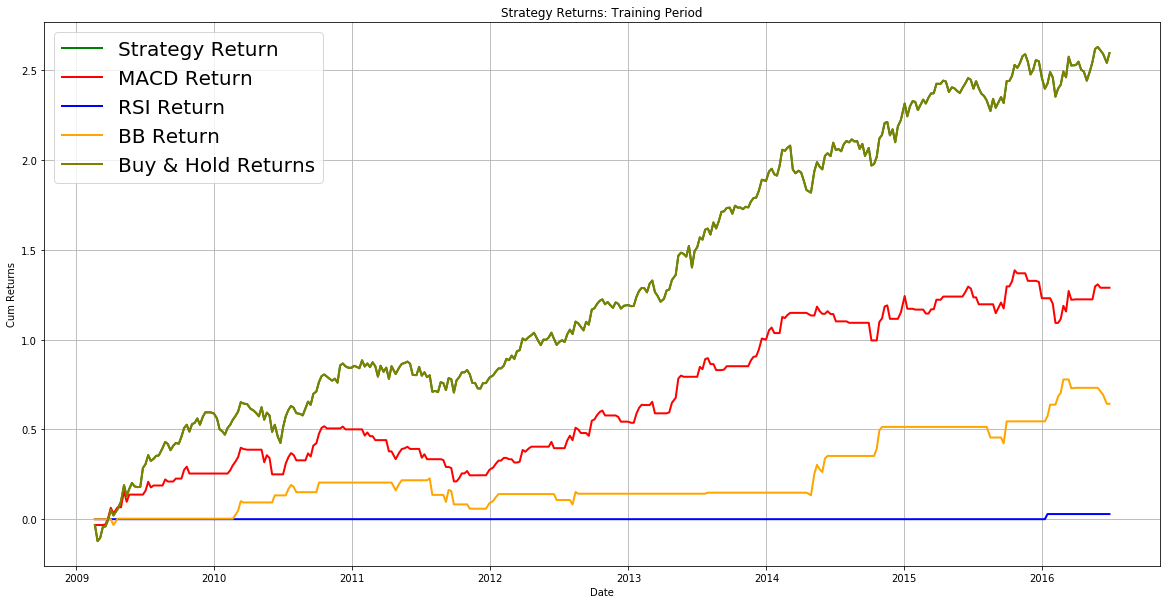

In [12]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(R1data.index, Cum_Return1, linewidth=2, color='green')
ax.plot(R1data.index, Cum_MACD1, linewidth=2, color='red')
ax.plot(R1data.index, Cum_RSI1, linewidth=2, color='blue')
ax.plot(R1data.index, Cum_BB1, linewidth=2, color='orange')
ax.plot(R1data.index, BH_Cum_Return1, linewidth=2, color='olive')

ax.set(xlabel='Date', ylabel='Cum Returns',
       title='Strategy Returns: Training Period')
ax.grid()

ax.legend(fontsize=20, loc=0)

plt.show()

# Strategy Analysis: Test Period

In [13]:
#Prepare
Tdata = df_daily[-615:]
del Tdata ['Next Week Move']

inx = Tdata[['MACD', 'ADX', 'MHIST', 'RSI', 'BB', 'FI']]
inclose = Tdata['Close']

predictions =model.predict(inx)
Tdata['Predict'] = predictions

Ndata = Tdata[['Close', 'Predict', 'MACD', 'RSI', 'BB']]
Rdata = Ndata.iloc[::5, :]
Rdata['NextClose'] = Rdata['Close'].shift(-1)
Rdata.dropna(inplace=True)

#Strategy Return
Rdata['Strategy Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['Predict'] == 1 else 0, axis=1)
Total_Return = Rdata['Strategy Return'].sum()
Cum_Return = Rdata['Strategy Return'].cumsum()
print('The Total Return for the Strategy is:', Total_Return)

#MACD
Rdata['MACD Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['MACD'] == 1 else 0, axis=1)
Total_MACD = Rdata['MACD Return'].sum()
Cum_MACD = Rdata['MACD Return'].cumsum()
print('The Total Return for the MACD Strategy is:', Total_MACD)

#RSI
Rdata['RSI Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['RSI'] == 1 else 0, axis=1)
Total_RSI = Rdata['RSI Return'].sum()
Cum_RSI = Rdata['RSI Return'].cumsum()
print('The Total Return for the RSI Strategy is:', Total_RSI)

#BB
Rdata['BB Return'] = Rdata.apply(lambda x : np.log(x['NextClose']/x['Close']) if x['BB'] == 1 else 0, axis=1)
Total_BB = Rdata['BB Return'].sum()
Cum_BB = Rdata['BB Return'].cumsum()
print('The Total Return for the BB Strategy is:', Total_BB)


#Buy and Hold Return
Rdata['Buy & Hold Returns'] = np.log(Rdata['NextClose'] /Rdata['Close'])
BH_Return = Rdata['Buy & Hold Returns'].sum()
BH_Cum_Return = Rdata['Buy & Hold Returns'].cumsum()
print('The Buy and Hold Strategy Return is:', BH_Return)


The Total Return for the Strategy is: 0.27360087866304583
The Total Return for the MACD Strategy is: 0.08750080319023198
The Total Return for the RSI Strategy is: 0.036990495653461394
The Total Return for the BB Strategy is: -0.06703294261503326
The Buy and Hold Strategy Return is: 0.27360087866304583


# Plot Strategy Returns: Test Period

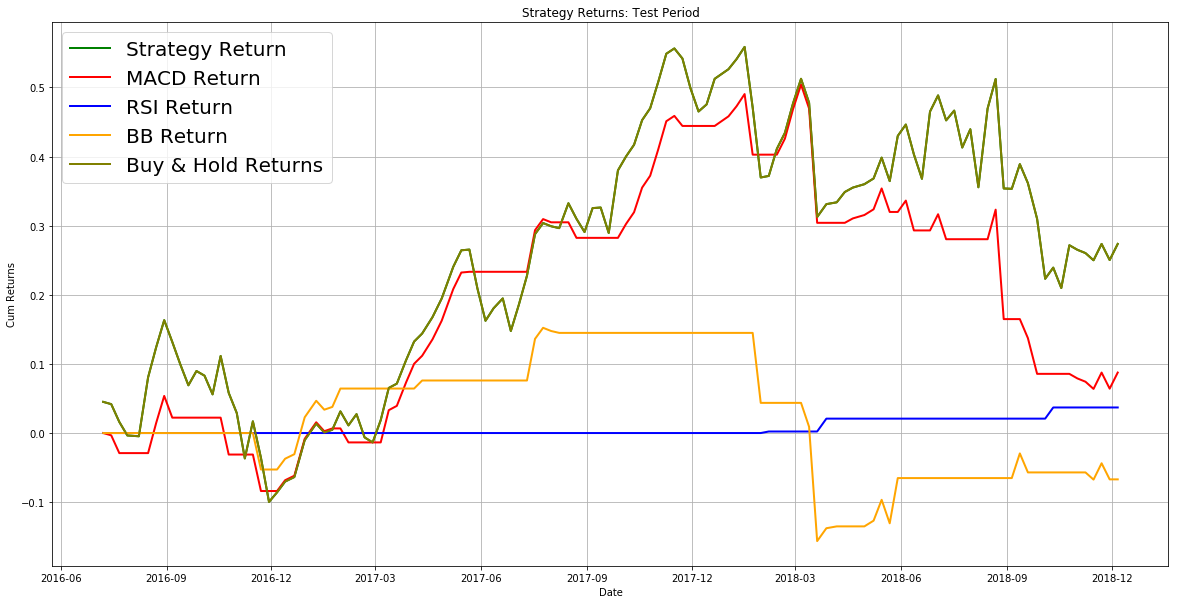

In [14]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Rdata.index, Cum_Return, linewidth=2, color='green')
ax.plot(Rdata.index, Cum_MACD, linewidth=2, color='red')
ax.plot(Rdata.index, Cum_RSI, linewidth=2, color='blue')
ax.plot(Rdata.index, Cum_BB, linewidth=2, color='orange')
ax.plot(Rdata.index, BH_Cum_Return, linewidth=2, color='olive')

ax.set(xlabel='Date', ylabel='Cum Returns',
       title='Strategy Returns: Test Period')
ax.grid()

ax.legend(fontsize=20, loc=0)

plt.show()

In [15]:
Rtdata = Rdata[['Strategy Return', 'MACD Return', 'RSI Return', 'BB Return', 'Buy & Hold Returns']]
Rtdata.to_csv('NPN_Rt_ca.csv')